# IFT6135 - assignement 1, problem 1: MLP with 2 hidden layers
## Éric Girard, Camille Rochefort-Boulanger, Emad Takla

In [0]:
import numpy as np
import matplotlib
import random
import matplotlib.pyplot as plt
import pandas as pd
import gzip,pickle
import numpy.matlib
import time

In [0]:
#MNIST data
f = gzip.open('mnist.pkl.gz')
data_mnist = pickle.load(f, encoding='latin1')
train_data_mnist = data_mnist[0]
valid_data_mnist = data_mnist[1]
test_data_mnist = data_mnist[2]

In [0]:
def softmax(x):
    #multiple sample (matrix)
    if len(np.shape(x)) > 1:
        x_max = np.max(x, axis = 1)
        exp = np.exp([x[i] - x_max[i] for i in range(len(x_max))])
        softmax = [exp[i] / exp[i].sum(axis = 0) for i in range(len(x_max))]
    #1 sample
    else:
        x_max = np.max(x)
        exp = np.exp(x - x_max)
        softmax = exp / exp.sum()
    return np.array(softmax)

def rect(x):
    return np.where(x>0.0, x, 0.0)

def grad_rect(x):
    return np.where(x>0.0, 1.0, 0.0)

def sigmoid(x):
    return 1/(1+np.exp(-x))

def grad_sigmoid(x):
    sig = sigmoid(x)
    return sig*(1-sig)

def onehot(x):
    labels = np.unique(x)
    onehots = np.zeros((len(x),len(labels))) #chaque row sera un onehot
    
    for val in range(len(labels)):
        onehots[np.where(val == x), val] = 1
    return(onehots)


# Neural network class

In [0]:
class NN:
    
    def __init__(self, d, dh1,dh2, m):
       
        self.d = d #input dimension
        self.dh1 = dh1 #first hidden layer size
        self.dh2 = dh2 #second layer size
        self.m = m #output layer size (number of class)
        self.theta = np.zeros(dh1*d + dh1 + dh1*dh2 + dh2+ dh2*m + m) #all network parameters
        
        #Parameters 
        self.W1 = self.theta[0:dh1*d].reshape(dh1,d)
        self.b1 = self.theta[dh1*d:dh1*d + dh1].reshape(dh1,)
        
        self.W2 = self.theta[dh1*d + dh1:dh1*d + dh1 + dh1*dh2].reshape(dh2, dh1)
        self.b2 = self.theta[dh1*d + dh1 + dh1*dh2:dh1*d + dh1 + dh1*dh2 + dh2].reshape(dh2,)
        
        self.W3 = self.theta[dh1*d + dh1 + dh1*dh2 + dh2:dh1*d + dh1 + dh1*dh2 + dh2+ dh2*m].reshape(m, dh2)
        self.b3 = self.theta[dh1*d + dh1 + dh1*dh2 + dh2+ dh2*m:].reshape(m,)
        
        self.grad = np.ones((dh1*d + dh1 + dh1*dh2 + dh2 + dh2*m + m))
       
    
    def init_weight(self,init_method):
        
        #Normal Gaussian
        if init_method == "gaussian":
            
            #W1 
            self.theta[0:self.dh1*self.d] =np.random.normal(0,
                                                            1,
                                                             self.dh1*self.d)
            #W2 
            self.theta[self.dh1*self.d + self.dh1 : 
                       self.dh1*self.d + self.dh1 + self.dh1*self.dh2] = np.random.normal(0,
                                                                                          1, 
                                                                                            self.dh2*self.dh1)
            #W3 
            self.theta[self.dh1*self.d + self.dh1 + self.dh1*self.dh2 +self.dh2 : 
                       self.dh1*self.d + self.dh1 + self.dh1*self.dh2 +self.dh2+ self.dh2*self.m] = np.random.normal(0,
                                                                                                                     1, 
                                                                                                                     self.m*self.dh2)
        
        #Glorot
        if init_method == "glorot":
            
            #W1 
            d1 = np.sqrt(6/(self.d+self.dh1))
            self.theta[0:self.dh1*self.d] = np.random.uniform(-d1, 
                                                               d1, 
                                                             self.dh1*self.d)
            #W2
            d2 = np.sqrt(6/(self.dh1+self.dh2))
            self.theta[self.dh1*self.d + self.dh1 : 
                       self.dh1*self.d + self.dh1 + self.dh1*self.dh2] = np.random.uniform(-d2, 
                                                                                            d2, 
                                                                                            self.dh2*self.dh1)
            #W3 
            d3 = np.sqrt(6/(self.dh2+self.m))
            self.theta[self.dh1*self.d + self.dh1 + self.dh1*self.dh2 +self.dh2 : 
                       self.dh1*self.d + self.dh1 + self.dh1*self.dh2 +self.dh2+ self.dh2*self.m] = np.random.uniform(-d3, 
                                                                                                                       d3, 
                                                                                                                       self.m*self.dh2)
    def fprop(self, x, y):
        #more than 1 sample (matrix operation)
        if len(np.shape(x)) > 1:
            
            #first hidden layer pre-activation
            self.h1a = np.dot(self.W1,x.T) + np.matlib.repmat(self.b1,x.shape[0],1).T
            #first hidden layer activation
            self.h1s = rect(self.h1a)
            
            #second layer pre-activation
            self.h2a = np.dot(self.W2,self.h1s) + np.matlib.repmat(self.b2,x.shape[0],1).T
            #second layer activation
            self.h2s = rect(self.h2a)
            
            #output layer pre-activation
            self.oa = np.dot(self.W3,self.h2s) + np.matlib.repmat(self.b3,x.shape[0],1).T
            #output layer activation
            self.os = softmax((self.oa).T).T  
            
            #loss (cross-entropy)
            self.loss = np.sum(-np.log(np.dot(self.os,y)))
        
        #compute for 1 sample
        else:
            
            self.h1a = np.dot(self.W1, x) + self.b1
            self.h1s = rect(self.h1a)
            
            self.h2a = np.dot(self.W2, self.h1s) + self.b2
            self.h2s = rect(self.h2a)
            
            self.oa =  np.dot(self.W3, self.h2s) + self.b3
            self.os = softmax(self.oa)
            
            self.loss = -np.log(np.dot(self.os, y))    

    def bprop(self, x, y):
        
        self.fprop(x, y)
        grad = []
        #compute for many sample
        if len(np.shape(x)) > 1:
            
            grad = []
            #grad of output layer pre-activation
            self.grad_oa = self.os-y.T
            #grad of output layer bias
            self.grad_b3 = np.sum(self.grad_oa,axis=1)
            #grad of output layer weights
            self.grad_W3 = np.dot(self.grad_oa,(self.h2s).T)
            
            #grad of 2nd hidden layer activation
            self.grad_h2s = np.dot((self.W3).T, self.grad_oa)
            #grad of 2nd hidden layer pre-activation
            self.grad_h2a = self.grad_h2s*grad_rect(self.h2a)
            #grad of 2nd hidden layer weights
            self.grad_W2 = np.dot(self.grad_h2a,(self.h1s).T)
            #grad of 2nd hidden layer bias
            self.grad_b2 = np.sum(self.grad_h2a,axis=1)
 
            #grad of 1st hidden layer activation
            self.grad_h1s = np.dot((self.W2).T, self.grad_h2a)
            #grad of 1st hidden layer pre-activation
            self.grad_h1a = self.grad_h1s*grad_rect(self.h1a)
            #grad of 1st hidden layer weights
            self.grad_W1 = np.dot(self.grad_h1a,x)
            #grad of 1st hidden layer bias
            self.grad_b1 = np.sum(self.grad_h1a,axis=1)
        
            self.grad = np.concatenate([np.concatenate(self.grad_W1),
                                        self.grad_b1,
                                        np.concatenate(self.grad_W2),
                                        self.grad_b2,
                                        np.concatenate(self.grad_W3),
                                        self.grad_b3])
        else:
            self.grad_oa = self.os - y
            self.grad_W3 = np.outer(self.grad_oa, self.h2s)
            self.grad_b3 = self.grad_oa
            
            self.grad_h2s = np.dot(np.transpose(self.W3), self.grad_oa)
            self.grad_h2a = self.grad_h2s * grad_rect(self.h2a)
            self.grad_W2 = np.outer(self.grad_h2a, self.h1s)
            self.grad_b2 = self.grad_h2a
            
            self.grad_h1s = np.dot(np.transpose(self.W2), self.grad_h2a)
            self.grad_h1a = self.grad_h1s * grad_rect(self.h1a)
            self.grad_W1 = np.outer(self.grad_h1a, x)
            self.grad_b1 = self.grad_h1a
            
            self.grad = np.concatenate([np.concatenate(self.grad_W1), 
                                        self.grad_b1, 
                                        np.concatenate(self.grad_W2), 
                                        self.grad_b2,
                                        np.concatenate(self.grad_W3),
                                        self.grad_b3])
            
            
    def train(self, data, label, K, max_iter = 10, learn_rate = .1,precision = 0.001):
        
        current_grad = self.grad
        previous_grad = current_grad + 1.
        nb_iter = 0
       
        loss_epoch = []
        accuracy_train = []
        accuracy_valid = []

        while nb_iter < max_iter:
            print("iter ",nb_iter)
            count_k = 0
            
            #loop on mini-batch
            while (count_k + K) <= len(data):
                
                previous_grad = current_grad.copy()
                
                if len(np.shape(data)) == 1:
                    self.bprop(data,label) #backprop (forward included)
                    sum_grad = self.grad.copy()
                else:
                    if K == 1:
                        self.bprop(data[count_k], label[count_k])
                    else :
                        self.bprop(data[count_k:count_k + K], label[count_k:count_k + K])
                    sum_grad = self.grad.copy()
                
                #Actualization of parameters 
                self.theta -= learn_rate * (1./K)*sum_grad 
                current_grad = self.theta.copy()
                count_k += K
                
                #stop training if convergence
                if (np.linalg.norm(current_grad - previous_grad) <= precision):
                    print("Convergence")
                    return loss_epoch,accuracy_train,accuracy_valid
            
            #accuracy and loss calculation (comment for faster training)
#             valid_prediction = self.predict(valid_data_mnist[0], probability = False)
#             train_prediction = self.predict(train_data_mnist_data, probability = False)
#             train_prediction_prob = self.predict(train_data_mnist_data, probability = True)
#             train_loss = (1./self.train_data[0].shape[0])* np.sum(-np.log(np.dot(train_prediction_prob.T,onehot(self.train_data[1]))))
            
#             loss_epoch.append(train_loss)
#             accuracy_train.append(100*(1-((sum(train_prediction != train_data_mnist[1].astype(float)))/len(train_data_mnist[1]))))
#             accuracy_valid.append(100*(1-((sum(valid_prediction != valid_data_mnist[1].astype(float)))/len(valid_data_mnist[1]))))
            
            nb_iter += 1
            
        print("Max iteration")   
        
        return loss_epoch,accuracy_train,accuracy_valid
    
    def init_error_output(self,train,valid,test):
       
        self.train_data = train
        self.valid_data = valid
        self.test_data = test
    
    #gradiant validation by finite difference   
    def check_grad(self, data, label, N):
        
        e = 1/N
        m=self.W2.size
        p = np.min([10,m])
        
        W2_index = self.dh1*self.d + self.dh1 #index of W2 in theta
        
        self.bprop(data, label) #compute grad
        start_loss = self.loss.copy() #assign initial loss
 
        self.diff_W2 = np.zeros(p)
        
        #for all W2 parameters 
        for i in range(p):
            self.theta[W2_index + i] += e # add epsilon to current W2
            self.fprop(data, label) #compute loss (from forward prop)
            self.diff_W2[i] = (self.loss - start_loss)/e #finite difference
            self.theta[W2_index + i] -= e # put back esilon to previous value
            
        #print(self.grad[W2_index:W2_index+10])
        #print(self.diff_W2)

        print("finite difference for W2 is")
        print(np.round(self.grad[W2_index:W2_index+10] - self.diff_W2, 6)) #difference between true grad and finite difference grad
       
        return (self.grad[W2_index:W2_index+10] - self.diff_W2)

    def predict(self,x,probability = False):
        
        pred = None
        prob = None
        
        if x.ndim > 1:
            pred = np.zeros(x.shape[0])
            prob = np.zeros((x.shape[0], self.m))
            for i in range(x.shape[0]):
                h1a_pred = self.b1 + np.dot(self.W1, x[i])
                h1s_pred = rect(h1a_pred)
                h2a_pred = self.b2 + np.dot(self.W2, h1s_pred)
                h2s_pred = rect(h2a_pred)
                oa_pred = self.b3 + np.dot(self.W3, h2s_pred)
                os_pred = softmax(oa_pred)
                pred[i] = np.argmax(os_pred)
                prob[i] = os_pred
                
        else:
            h1a_pred = self.b1 + np.dot(self.W1, x)
            h1s_pred = rect(h1a_pred)
            h2a_pred = self.b2 + np.dot(self.W2, x)
            h2s_pred = rect(h2a_pred)
            oa_pred = self.b3 + np.dot(self.W3, h2s_pred)
            os_pred = softmax(oa_pred)
            pred = np.argmax(os_pred)
            prob = os_pred
        
        if probability:
            return prob
        else:
            return pred
    

In [14]:
#"MAIN"

#Data
train_data_mnist_data = train_data_mnist[0]
train_data_mnist_label = onehot(train_data_mnist[1])

#Parameters
dh1 = 512
dh2 = 512
d = train_data_mnist_data.shape[1]
m = train_data_mnist_label.shape[1]
max_iter = 15
K = 100
LR = 0.1

nn_mnist = NN(d, dh1,dh2, m)
nn_mnist.init_weight("glorot")
nn_mnist.init_error_output(train_data_mnist,valid_data_mnist,test_data_mnist)
start_time = time.time()
nn_mnist.train(train_data_mnist_data, train_data_mnist_label, K,learn_rate = LR, max_iter = max_iter)
print("Training time : %s seconds ---" % (time.time() - start_time))

valid_prediction = nn_mnist.predict(valid_data_mnist[0], probability = False)
train_prediction = nn_mnist.predict(train_data_mnist_data, probability = False)
test_prediction = nn_mnist.predict(test_data_mnist[0], probability = False)

print("Training error : ",100*((sum(train_prediction != train_data_mnist[1].astype(float)))/len(train_data_mnist[1])), " %")
print("Validation error : ",100*((sum(valid_prediction != valid_data_mnist[1].astype(float)))/len(valid_data_mnist[1])), " %")
print("Test error : ",100*((sum(test_prediction != test_data_mnist[1].astype(float)))/len(test_data_mnist[1])), " %")

iter  0
iter  1
iter  2
iter  3
iter  4
iter  5
iter  6
iter  7
iter  8
iter  9
iter  10
iter  11
iter  12
iter  13
iter  14
Max iteration
Training time : 247.1409785747528 seconds ---
Training error :  0.27999999999999997  %
Validation error :  2.12  %
Test error :  2.06  %


In [17]:
'''

INITIALIZATION experiment

'''
#Donnees
train_data_mnist_data = train_data_mnist[0]
train_data_mnist_label = onehot(train_data_mnist[1])

#Parametres
dh1 = 512
dh2 = 512
d = train_data_mnist_data.shape[1]
m = train_data_mnist_label.shape[1]
max_iter = 10
K = 100
LR = 0.1

# Zero init
nn_mnist = NN(d, dh1,dh2, m)
nn_mnist.init_error_output(train_data_mnist,valid_data_mnist,test_data_mnist)
start_time = time.time()
loss_zero,train_acc,valid_acc = nn_mnist.train(train_data_mnist_data, train_data_mnist_label, K,learn_rate = LR, max_iter = max_iter)

#Normal Gaussian init
nn_mnist = NN(d, dh1,dh2, m)
nn_mnist.init_weight("gaussian")
nn_mnist.init_error_output(train_data_mnist,valid_data_mnist,test_data_mnist)
start_time = time.time()
loss_normal,train_acc,valid_acc = nn_mnist.train(train_data_mnist_data, train_data_mnist_label, K,learn_rate = LR, max_iter = max_iter)

#Normal Gaussian init
nn_mnist = NN(d, dh1,dh2, m)
nn_mnist.init_weight("glorot")
nn_mnist.init_error_output(train_data_mnist,valid_data_mnist,test_data_mnist)
start_time = time.time()
loss_glorot,train_acc,valid_acc = nn_mnist.train(train_data_mnist_data, train_data_mnist_label, K,learn_rate = LR, max_iter = max_iter)

#LOSS plot
epoch = range(10)

fig, ax = plt.subplots()
ax.plot(epoch,loss_zero,label="Zero")
ax.plot(epoch,loss_normal,label="Gaussian")
ax.plot(epoch,loss_glorot,label="Glorot")

#ax.axis([0, 1000, 0, 0.12])
plt.xlabel('epoch')
plt.ylabel('Loss')
#plt.title("Loss curve")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
#plt.show()
plt.savefig("Initialization",dpi=300)


iter  0
iter  1


KeyboardInterrupt: ignored

iter  0
iter  1
iter  2
iter  3
iter  4
iter  5
iter  6
iter  7
iter  8
iter  9
Iteration maximal
iter  0
iter  1
iter  2
iter  3
iter  4
iter  5
iter  6
iter  7
iter  8
iter  9
Iteration maximal
iter  0
iter  1
iter  2
iter  3
iter  4
iter  5
iter  6
iter  7
iter  8
iter  9
Iteration maximal
iter  0
iter  1
iter  2
iter  3
iter  4
iter  5
iter  6
iter  7
iter  8
iter  9
Iteration maximal
iter  0
iter  1
iter  2
iter  3
iter  4
iter  5
iter  6
iter  7
iter  8
iter  9
Iteration maximal
iter  0
iter  1
iter  2
iter  3
iter  4
iter  5
iter  6
iter  7
iter  8
iter  9
Iteration maximal


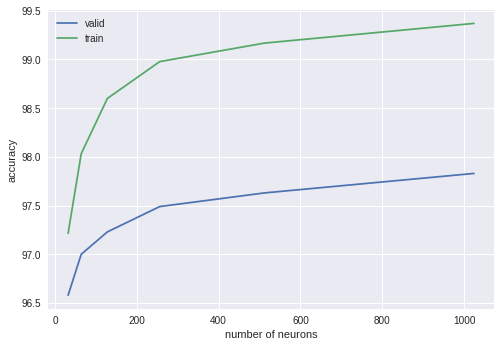

In [21]:
'''
HYPERPARAMETER SEARCH (number of neurons)
'''

accuracy_results_valid = []
accuracy_results_train = []

#Donnees
train_data_mnist_data = train_data_mnist[0]
train_data_mnist_label = onehot(train_data_mnist[1])

#Parametres
d = train_data_mnist_data.shape[1]
m = train_data_mnist_label.shape[1]
max_iter = 10
K = 100
LR = 0.1
n_neurons = [32,64,128,256,512,1024]

for n in n_neurons:

    nn_mnist = NN(d, n, n, m)
    nn_mnist.init_weight("glorot")
    nn_mnist.init_error_output(train_data_mnist,valid_data_mnist,test_data_mnist)
    nn_mnist.train(train_data_mnist_data, train_data_mnist_label, K,learn_rate = LR, max_iter = max_iter)
    valid_prediction = nn_mnist.predict(valid_data_mnist[0], probability = False)
    train_prediction = nn_mnist.predict(train_data_mnist_data, probability = False)
    accuracy_results_valid.append(100*(1-((sum(valid_prediction != valid_data_mnist[1].astype(float)))/len(valid_data_mnist[1]))))
    accuracy_results_train.append(100*(1-((sum(train_prediction != train_data_mnist[1].astype(float)))/len(train_data_mnist[1]))))
    
#accuracy/number of neurons plot
epoch = range(10)

fig, ax = plt.subplots()
ax.plot(n_neurons,accuracy_results_valid,label="valid")
ax.plot(n_neurons,accuracy_results_train,label="train")

#ax.axis([0, 1000, 0, 0.12])
plt.xlabel('number of neurons')
plt.ylabel('accuracy')
#plt.title("Effect of number of neurons on accuracy")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
#plt.show()
plt.savefig("Hyperparameter_neurons",dpi=300)

iter  0
iter  1
iter  2
iter  3
iter  4
iter  5
iter  6
iter  7
iter  8
iter  9
Iteration maximal
iter  0
iter  1
iter  2
iter  3
iter  4
iter  5
iter  6
iter  7
iter  8
iter  9
Iteration maximal
iter  0
iter  1
iter  2
iter  3
Convergence
iter  0
Convergence
iter  0
Convergence


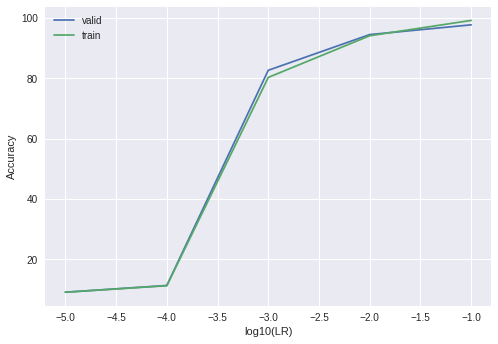

In [31]:
'''
HYPERPARAMETER SEARCH (Learning Rate)
'''

accuracy_results_valid = []
accuracy_results_train = []

#Donnees
train_data_mnist_data = train_data_mnist[0]
train_data_mnist_label = onehot(train_data_mnist[1])

#Parametres
d = train_data_mnist_data.shape[1]
m = train_data_mnist_label.shape[1]
max_iter = 10
K = 100
n = 512
LR_list = [10**(-1),10**(-2),10**(-3),10**(-4),10**(-5)]

for LR in LR_list:

    nn_mnist = NN(d, n, n, m)
    nn_mnist.init_weight("glorot")
    nn_mnist.init_error_output(train_data_mnist,valid_data_mnist,test_data_mnist)
    nn_mnist.train(train_data_mnist_data, train_data_mnist_label, K,learn_rate = LR, max_iter = max_iter)
    valid_prediction = nn_mnist.predict(valid_data_mnist[0], probability = False)
    train_prediction = nn_mnist.predict(train_data_mnist_data, probability = False)
    accuracy_results_valid.append(100*(1-((sum(valid_prediction != valid_data_mnist[1].astype(float)))/len(valid_data_mnist[1]))))
    accuracy_results_train.append(100*(1-((sum(train_prediction != train_data_mnist[1].astype(float)))/len(train_data_mnist[1]))))
    

#LR plot
fig, ax = plt.subplots()
ax.plot(np.log10(LR_list),accuracy_results_valid,label="valid")
ax.plot(np.log10(LR_list),accuracy_results_train,label="train")

#ax.axis([0, 1000, 0, 0.12])
plt.xlabel('log10(LR)')
plt.ylabel('Accuracy')
#plt.title("effect of LR on valid accuracy")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
#plt.show()
plt.savefig("Hyperparameter_LR",dpi=300)

iter  0
iter  1
iter  2
iter  3
iter  4
iter  5
iter  6
iter  7
iter  8
iter  9
iter  10
iter  11
iter  12
iter  13
iter  14
Iteration maximal


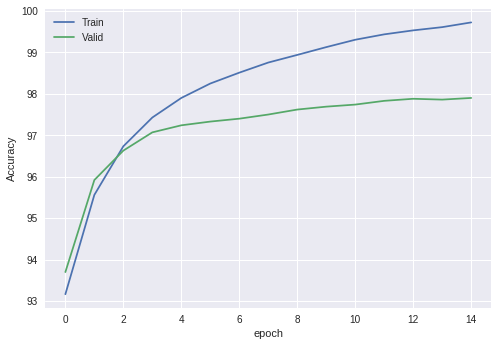

In [32]:
'''
HYPERPARAMETER SEARCH (epoch)
'''
#Donnees
train_data_mnist_data = train_data_mnist[0]
train_data_mnist_label = onehot(train_data_mnist[1])

#Parametres
dh1 = 512
dh2 = 512
d = train_data_mnist_data.shape[1]
m = train_data_mnist_label.shape[1]
max_iter = 15
K = 100
LR = 0.1

# Zero init
nn_mnist = NN(d, dh1,dh2, m)
nn_mnist.init_weight("glorot")
nn_mnist.init_error_output(train_data_mnist,valid_data_mnist,test_data_mnist)
start_time = time.time()
loss_zero,train_acc,valid_acc = nn_mnist.train(train_data_mnist_data, train_data_mnist_label, K,learn_rate = LR, max_iter = max_iter)

#Accuracy/epoch plot
epoch = range(len(train_acc))

fig, ax = plt.subplots()
ax.plot(epoch,train_acc,label="Train")
ax.plot(epoch,valid_acc,label="Valid")

#ax.axis([0, 1000, 0, 0.12])
plt.xlabel('epoch')
plt.ylabel('Accuracy')
#plt.title("Train and Valid accuracy curves)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
#plt.show()
plt.savefig("Hyperparameter_epoch",dpi=300)

iter  0
iter  1
iter  2
iter  3
iter  4
iter  5
iter  6
iter  7
iter  8
iter  9
iter  10
iter  11
iter  12
iter  13
iter  14
Iteration maximal
[1.96141261e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.60202685e-05 8.20582874e-05 1.12675188e-04
 0.00000000e+00 0.00000000e+00]
[1.96152364e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.60369490e-05 8.20777231e-05 1.12711835e-04
 0.00000000e+00 0.00000000e+00]
Difference finie pour W2
[-0.  0.  0.  0.  0. -0. -0. -0.  0.  0.]
[1.96141261e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.60202685e-05 8.20582874e-05 1.12675188e-04
 0.00000000e+00 0.00000000e+00]
[1.96142371e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.60219363e-05 8.20602307e-05 1.12678852e-04
 0.00000000e+00 0.00000000e+00]
Difference finie pour W2
[-0.  0.  0.  0.  0. -0. -0. -0.  0.  0.]
[1.96141261e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.60202685e-05 8.20582874e-05 

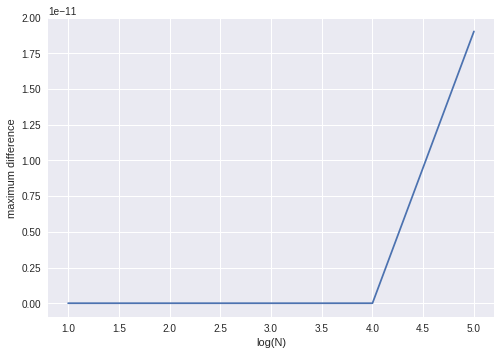

In [40]:
'''
VALIDATE GRADIENTS USING FINITE DIFFERENCE
'''

#Donnees
train_data_mnist_data = train_data_mnist[0]
train_data_mnist_label = onehot(train_data_mnist[1])

#Parametres
dh1 = 512
dh2 = 512
d = train_data_mnist_data.shape[1]
m = train_data_mnist_label.shape[1]
max_iter = 15
K = 100
LR = 0.1

# Zero init
nn_mnist = NN(d, dh1,dh2, m)
nn_mnist.init_weight("glorot")
nn_mnist.init_error_output(train_data_mnist,valid_data_mnist,test_data_mnist)
start_time = time.time()

nn_mnist.train(train_data_mnist_data, train_data_mnist_label, K,learn_rate = LR, max_iter = max_iter)

N = [10**(1),10**(2),10**(3),10**(4),10**(5)]
finite_diff_list = []

for n in N:
    finite_diff_list.append(nn_mnist.check_grad(train_data_mnist_data[0],train_data_mnist_label[0],n))
    
max_list = [np.max(l) for l in finite_diff_list]

#plot FINITE diff

fig, ax = plt.subplots()
ax.plot(np.log10(N),max_list)

#ax.axis([0, 1000, 0, 0.12])
plt.xlabel('log(N)')
plt.ylabel('maximum difference')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

#plt.show()
plt.savefig("finite_difference",dpi=300)

